In [ ]:
#Import required libraries
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import relu
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
"""initialise the constants"""

prediction_days = 13
features = ["High", "Low", "Open", "Close"]
start_date, end_date = "2012-1-1", "2020-1-1"
training_ratio = 0.9

In [ ]:
"""A function that returns data formatted for RNN when scaled data and the numbers of data points per feature is provided"""
def PreProcessing(scaled_data, data_points):
  #preparing feature and target arrays
  x = []
  y = []

  for i in range(data_points, len(scaled_data)):
    x.append(scaled_data[i-data_points:i,:scaled_data.shape[1]])
    y.append(scaled_data[i, :scaled_data.shape[1]])

  x, y = np.array(x), np.array(y)

  return x, y


In [ ]:
"""import the data"""
df = web.data.DataReader("FB", "naver", start_date, end_date)

ParseError: ignored

In [ ]:
"""Divide the data into training and validation data"""

train_range = int(training_ratio*len(df))

train_df = df.copy()[features].iloc[:train_range]
test_df = df.copy()[features].iloc[train_range:]

print(train_df.tail(), test_df.head())


                  High         Low        Open       Close
Date                                                      
2019-03-22  167.419998  164.089996  165.649994  164.339996
2019-03-25  166.539993  162.000000  163.000000  166.289993
2019-03-26  169.449997  166.350006  167.350006  167.679993
2019-03-27  168.940002  164.789993  167.850006  165.869995
2019-03-28  166.720001  163.330002  164.570007  165.550003                   High         Low        Open       Close
Date                                                      
2019-03-29  167.190002  164.809998  166.389999  166.690002
2019-04-01  168.899994  167.279999  167.830002  168.699997
2019-04-02  174.899994  169.550003  170.139999  174.199997
2019-04-03  177.960007  172.949997  174.500000  173.539993
2019-04-04  178.000000  175.529999  176.020004  176.020004


In [ ]:
"""Preparing the data for RNN"""

#Scaling the data to be values between 0 and 1
scaler = StandardScaler()


scaler_fitting_data = df.copy()[features]


scaler = scaler.fit(scaler_fitting_data)


scaled_training_data = scaler.transform(train_df)
scaled_testing_data = scaler.transform(test_df)

validation_dates = test_df.index.values

#preparing feature and target arrays
x_train, y_train = PreProcessing(scaled_training_data, prediction_days)
x_test, scaled_validation_values = PreProcessing(scaled_testing_data, prediction_days)
x_train.min()

-1.6150535500269054

In [ ]:
#Building the model
model = Sequential()

model.add(LSTM(512, return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(128, activation=relu))
model.add(Dense(len(features), activation=relu))

model.compile(
    optimizer= "adam",
    loss= "mean_squared_error",
    
)

model.fit(x_train,y_train, epochs=25, batch_size=32) 

Epoch 1/25
54/54 [==============================] - 12s 181ms/step - loss: 0.5717
Epoch 2/25
54/54 [==============================] - 10s 177ms/step - loss: 0.5493
Epoch 3/25
54/54 [==============================] - 10s 178ms/step - loss: 0.5503
Epoch 4/25
54/54 [==============================] - 10s 187ms/step - loss: 0.5486
Epoch 5/25
54/54 [==============================] - 10s 184ms/step - loss: 0.5487
Epoch 6/25
54/54 [==============================] - 10s 185ms/step - loss: 0.5486
Epoch 7/25
54/54 [==============================] - 10s 183ms/step - loss: 0.5486
Epoch 8/25
54/54 [==============================] - 10s 184ms/step - loss: 0.5484
Epoch 9/25
54/54 [==============================] - 10s 181ms/step - loss: 0.5481
Epoch 10/25
54/54 [==============================] - 9s 172ms/step - loss: 0.5486
Epoch 11/25
54/54 [==============================] - 10s 176ms/step - loss: 0.5480
Epoch 12/25
54/54 [==============================] - 10s 177ms/step - loss: 0.5480
Epoch 13/25
54

In [ ]:
scaled_predictions = model.predict(x_test)

predictions = scaler.inverse_transform(scaled_predictions)
validation_values = scaler.inverse_transform(scaled_validation_values)

validation_df = pd.DataFrame()

for i in range(predictions.shape[1]):
  validation_df[f"Validation{features[i]}"], validation_df[f"Predicted{features[i]}"] = validation_values[:,i].reshape(-1), predictions[:,i].reshape(-1)

validation_df.set_index(validation_dates[prediction_days:], inplace=True)


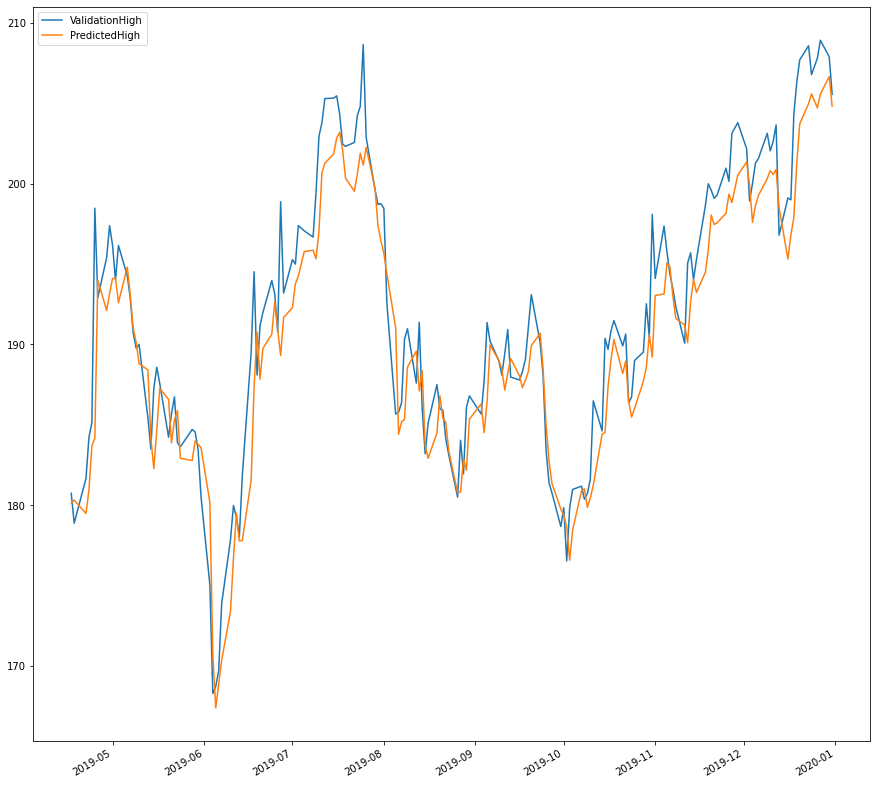

In [ ]:
validation_df[["ValidationHigh", "PredictedHigh"]].plot(figsize=(15,15))

In [ ]:
validation_df.describe()

,ValidationHigh,PredictedHigh,ValidationLow,PredictedLow,ValidationOpen,PredictedOpen,ValidationClose,PredictedClose
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,191.652458,189.978745,187.695140,186.913132,189.816033,188.811646,189.709665,188.409256
std,8.727128,8.008657,8.945501,8.077068,8.764126,8.028525,8.863734,8.025109
min,168.279999,167.386261,160.839996,163.621490,163.710007,165.990845,164.149994,165.510803
25%,185.669998,184.420303,181.464996,181.358322,183.645004,183.221146,183.144997,182.831421
50%,190.839996,189.216507,187.229996,186.183838,189.559998,188.014725,189.020004,187.619247
75%,198.735001,195.820786,193.955002,192.854172,196.289993,194.673401,196.574997,194.278595
max,208.929993,206.668793,206.589996,203.788635,208.669998,205.571609,208.100006,205.185745


In [ ]:
validation_df.head(20)

,ValidationHigh,PredictedHigh,ValidationLow,PredictedLow,ValidationOpen,PredictedOpen,ValidationClose,PredictedClose
2019-04-17,180.740005,180.115494,178.360001,177.293869,179.600006,179.076889,178.779999,178.662537
2019-04-18,178.880005,180.317444,177.339996,177.487518,178.800003,179.285828,178.279999,178.870087
2019-04-22,181.669998,179.485214,178.250000,176.612549,178.250000,178.443054,181.440002,178.017899
2019-04-23,184.220001,180.936188,181.479996,178.111267,182.740005,179.911072,183.779999,179.511337
2019-04-24,185.139999,183.685776,181.649994,180.957336,184.490005,182.679764,182.580002,182.319214
2019-04-25,198.479996,184.164093,192.119995,181.367783,196.979996,183.114624,193.259995,182.724274
2019-04-26,192.899994,194.009964,189.089996,191.556259,192.500000,193.089951,191.490005,192.847595
2019-04-29,195.410004,192.112732,190.649994,189.306931,190.949997,190.964767,194.779999,190.583801
2019-04-30,197.389999,193.168152,192.279999,190.295685,194.190002,192.009964,193.399994,191.605301
2019-05-01,196.179993,194.097275,193.009995,191.179749,194.779999,192.937088,193.029999,192.520126


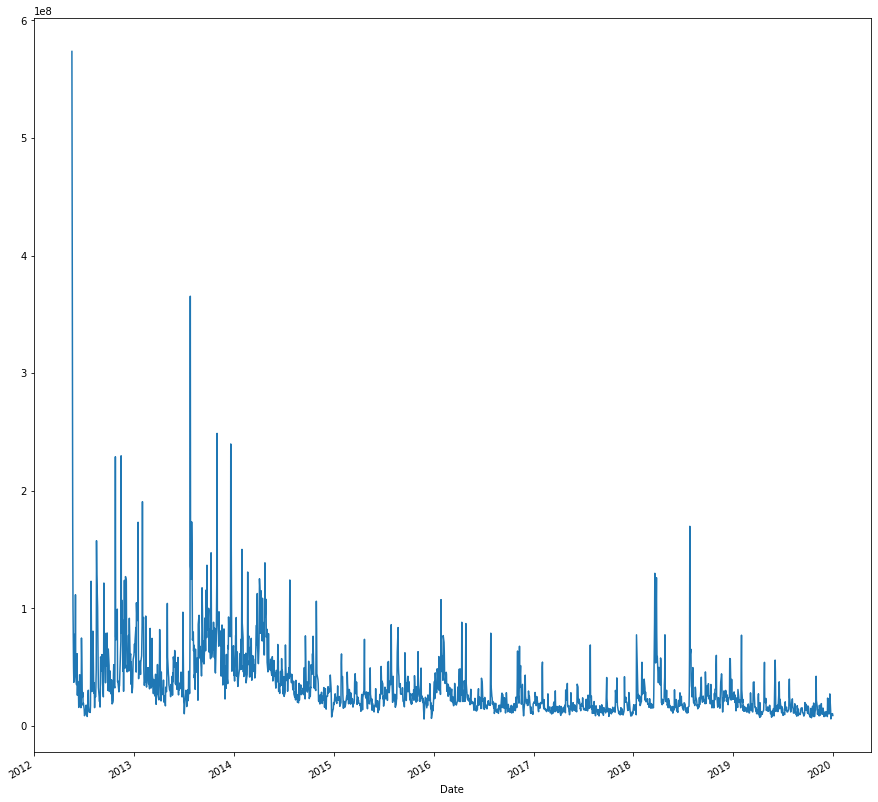

In [ ]:
df["Volume"].plot(figsize=(15,15))

In [ ]:
df.columns[:-2]

Index(['High', 'Low', 'Open', 'Close'], dtype='object')